In [15]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers, backend 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate, BatchNormalization, LeakyReLU, Flatten
import joblib

import time
from typing import Tuple, List
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [16]:
import seaborn as sns
sns.set_theme()

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [18]:
def load_data() -> pd.DataFrame:
    diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/german_credit.arff')
    diab_df = pd.DataFrame(diab_arf[0])
    return diab_df
    
def prepare():
    cred_df = load_data()
    # y = cred_df.pop('21')
    # print(cred_df.describe())
    cat_labels = ['1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20']
    # One hot encoding
    df = pd.get_dummies(cred_df, columns=cat_labels)
    df = df.astype('float')
    # numeric scaling
    scale = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scale.fit_transform(df)
    df.loc[:, :] = scaled_values

    return df

In [19]:
df_credit = prepare()
df_credit.head()

,2,5,8,11,13,16,18,21,1_b'A11',1_b'A12',1_b'A13',1_b'A14',3_b'A30',3_b'A31',3_b'A32',3_b'A33',3_b'A34',4_b'A40',4_b'A41',4_b'A410',4_b'A42',4_b'A43',4_b'A44',4_b'A45',4_b'A46',4_b'A48',4_b'A49',6_b'A61',6_b'A62',6_b'A63',6_b'A64',6_b'A65',7_b'A71',7_b'A72',7_b'A73',7_b'A74',7_b'A75',9_b'A91',9_b'A92',9_b'A93',9_b'A94',10_b'A101',10_b'A102',10_b'A103',12_b'A121',12_b'A122',12_b'A123',12_b'A124',14_b'A141',14_b'A142',14_b'A143',15_b'A151',15_b'A152',15_b'A153',17_b'A171',17_b'A172',17_b'A173',17_b'A174',19_b'A191',19_b'A192',20_b'A201',20_b'A202'
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0


In [20]:
df_train, df_test = split_df_to_train_val(df_credit, 0.7)
y_train = df_train.pop('21')
y_test = df_test.pop('21')

df_train.head()

,2,5,8,11,13,16,18,1_b'A11',1_b'A12',1_b'A13',1_b'A14',3_b'A30',3_b'A31',3_b'A32',3_b'A33',3_b'A34',4_b'A40',4_b'A41',4_b'A410',4_b'A42',4_b'A43',4_b'A44',4_b'A45',4_b'A46',4_b'A48',4_b'A49',6_b'A61',6_b'A62',6_b'A63',6_b'A64',6_b'A65',7_b'A71',7_b'A72',7_b'A73',7_b'A74',7_b'A75',9_b'A91',9_b'A92',9_b'A93',9_b'A94',10_b'A101',10_b'A102',10_b'A103',12_b'A121',12_b'A122',12_b'A123',12_b'A124',14_b'A141',14_b'A142',14_b'A143',15_b'A151',15_b'A152',15_b'A153',17_b'A171',17_b'A172',17_b'A173',17_b'A174',19_b'A191',19_b'A192',20_b'A201',20_b'A202'
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
5,-0.058824,-0.031033,-0.333333,1.000000,-0.428571,-1.000000,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0


In [21]:
# rf.fit(df_train, y_train)
# rf.oob_score_

# using cross-validation and grid-search

# rf = RandomForestClassifier()
# parameters = {
#     'max_features': ('auto', 'sqrt', 10, 12, 20, 30),
#     'max_depth': (5, 10, 15, None),
#     'n_estimators': (100, 200, 500, 1000, 2000)
# }
# gs_rf = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
# gs_rf.fit(df_train, y_train)
# joblib.dump(gs_rf, "/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")


In [22]:
gs_rf = joblib.load("/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")

In [23]:
gs_rf.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}

In [24]:
gs_rf.best_score_

0.7595644790730196

In [25]:
p = gs_rf.predict(df_test)
confusion_matrix(y_test.values, p)

array([[201,   4],
       [  6,  72]])

In [26]:
print(classification_report(y_test.values, p,labels=[1,-1]))

              precision    recall  f1-score   support

           1       0.95      0.92      0.94        78
          -1       0.97      0.98      0.98       205

    accuracy                           0.96       283
   macro avg       0.96      0.95      0.96       283
weighted avg       0.96      0.96      0.96       283



In [27]:

class BB_GAN_Cred:
    def __init__(self, black_box_model, latent_dim, gen_out_size, gen_final_activation='tanh'):
        self.latent_dim = latent_dim
        self.generator_vector_size = gen_out_size
        self.discriminator_input_shape = (self.generator_vector_size,)

        self.generator = self.make_generator_model(gen_final_activation)
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)
        self.gs_rf = black_box_model

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False

        g_input = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))
        g_sample = g_model([g_input, c_input])
        d_desision = d_model([g_sample, c_input, c_input])
        gan_model = Model([g_input, c_input], d_desision)
        # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.6, beta_2=0.999)
        gan_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return gan_model

    def make_generator_model(self, gen_final_activation):
        input_noise = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))
        concat_layer_c = concatenate([input_noise, c_input])
        dense_1 = Dense(128, use_bias=True)(concat_layer_c)
        dense_1_bn = BatchNormalization()(dense_1)
        dense_1_lr = LeakyReLU()(dense_1_bn)
        dense_1_do = Dropout(0.25)(dense_1_lr)
        dense_2 = Dense(256)(dense_1_do)
        dense_2_bn = BatchNormalization()(dense_2)
        dense_2_lr = LeakyReLU()(dense_2_bn)
        dense_2_do = Dropout(0.25)(dense_2_lr)
        dense_3 = Dense(512)(dense_2_do)
        dense_3_bn = BatchNormalization()(dense_3)
        dense_3_lr = LeakyReLU()(dense_3_bn)
        dense_3_do = Dropout(0.25)(dense_3_lr)
        final_layer = Dense(self.generator_vector_size, activation=gen_final_activation)(dense_3_do)
        # concat_layer = concatenate([final_layer, c_input])
        model = Model(inputs=[input_noise, c_input], outputs=final_layer)

        model.summary()
        return model


    def make_discriminator_model(self):

        input_sample = Input(shape=self.discriminator_input_shape,)
        cy1_input = Input(shape=(1,))
        cy2_input = Input(shape=(1,))

        concat_layer_c = concatenate([input_sample, cy1_input, cy2_input])
        dense_1 = Dense(512, use_bias=True)(concat_layer_c)
        dense_1_lr = LeakyReLU()(dense_1)
        dense_1_do = Dropout(0.2)(dense_1_lr)
        dense_2 = Dense(256)(dense_1_do)
        dense_2_lr = LeakyReLU()(dense_2)
        dense_2_do = Dropout(0.2)(dense_2_lr)
        dense_3 = Dense(128)(dense_2_do)
        dense_3_lr = LeakyReLU()(dense_3)
        dense_3_do = Dropout(0.2)(dense_3_lr)
        flatten = Flatten()(dense_3_do)
        # layer_final_sm = Dense(2, activation='softmax')(flatten)
        final_layer = Dense(1, activation='sigmoid')(flatten)
        # concat_layer = concatenate([dense_2_do, c_input, y_input])
        model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)

        opt = tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.8)
        # opt = tf.keras.optimizers.Adam(lr=0.000015, beta_1=0.95)  # lr=0.0002, beta_1=0.5, beta_2=0.999
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

    def generate_real_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        # prepare samples
        noise = np.random.uniform(-1, 1, size=(n_samples, self.latent_dim))
        c_1 = np.random.random((n_samples, ))
        samples_1 = self.generator.predict([noise, c_1])
        y_1 = self.gs_rf.predict_proba(samples_1)[:, 0]
        valid = np.ones((n_samples, 1))
        return samples_1, c_1, y_1, valid

    def generate_fake_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        noise = np.random.uniform(-1, 1, size=(n_samples, self.latent_dim))
        c_2 = np.random.random((n_samples, ))
        samples_2 = self.generator.predict([noise, c_2])
        y_2 = self.gs_rf.predict_proba(samples_2)[:, 0]
        invalid = np.zeros((n_samples, 1))
        return samples_2, y_2, c_2, invalid

    def train(self, epochs, batch_size=8):
        valid = np.ones((batch_size, 1))
        invalid = np.zeros((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        # fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        d_fake_losses = np.zeros((epochs, 1))
        d_fake_accuracies = np.zeros((epochs, 1))
        d_real_losses = np.zeros((epochs, 1))
        d_real_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))
        best_epoch = 0
        d_acc_delta_to_0_5 = 1
        losses_delta = 1
        real_2_fake_acc_delta = 1
        for i, epoch in enumerate(range(epochs)):
            # prepare samples
            noise = np.random.uniform(-1, 1, size=(batch_size, self.latent_dim))
            c_1 = np.random.random((batch_size, ))
            samples_1 = self.generator.predict([noise, c_1])
            y_1 = self.gs_rf.predict_proba(samples_1)[:, 0]  # evaluate Y via RF classifier take first column confidence
            c_2 = np.random.random((batch_size, ))
            samples_2 = self.generator.predict([noise, c_2])
            y_2 = self.gs_rf.predict_proba(samples_2)[:, 0]  # evaluate Y via RF classifier take first column confidence

            # create training set for the discriminator
            # swapping places between 'y' and 'c' trains the Discriminator
            # to realize that right hand side parameter is fake (and the opposite)
            samples, c, y_bb = np.vstack((samples_1, samples_2)), np.concatenate((c_1, y_2), axis=None), np.concatenate((y_1, c_2), axis=None)

            # update discriminator model weights
            d_loss, d_acc = self.discriminator.train_on_batch([samples, c, y_bb], np.vstack((valid, invalid)))

            # evaluate discriminator on real examples
            samples_real, c_real, y_bb_real, y_real = self.generate_real_x_y(batch_size)
            d_loss_real, d_acc_real = self.discriminator.evaluate([samples_real, c_real, y_bb_real], y_real, verbose=0)
            # evaluate discriminator on fake examples
            samples_fake, c_fake, y_bb_fake, y_fake = self.generate_fake_x_y(batch_size)
            d_loss_fake, d_acc_fake = self.discriminator.evaluate([samples_fake, c_fake, y_bb_fake], y_fake, verbose=0)

            d_fake_losses[i] = d_loss_fake
            d_real_losses[i] = d_loss_real
            d_fake_accuracies[i] = d_acc_fake
            d_real_accuracies[i] = d_acc_real

            # noise = np.random.normal(0, 1, (batch_size * 2, self.latent_dim)) # Carmel,  WHY TWISE?
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            noise = np.random.uniform(-1, 1, size=(batch_size * 2, self.latent_dim))
            # c = np.random.normal(0, 1, (batch_size * 2, ))
            c = np.random.random((batch_size * 2, ))
            g_loss, g_acc = self.gan.train_on_batch([noise, c], valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc

            if i % 50 == 0:
                print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
                if 800 <= i:
                    if abs(g_loss - d_loss) < 0.2: # check that losses converged
                        if abs(d_acc - 0.5) < 0.2 and abs( d_acc_fake - d_acc_real) < 0.2 : # save generator model for closest to 0.5 accuracy
                            # filename = 'generator_model.h5'
                            filename = 'generator_model_%03d.h5' % epoch

                            self.generator.save(filename)
                            best_epoch = epoch

        print(f'Best epoch: {best_epoch}')
        return d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies

In [ ]:
iterations = 5000
gan = BB_GAN_Cred(gs_rf, 30, 61, 'tanh')
# d_losses, d_accuracies, g_losses, g_accuracies = gan.train(epochs=iterations, batch_size=32)
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(epochs=iterations, batch_size=16)

In [44]:
iterations = 3000
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(epochs=iterations, batch_size=16)

epoch 0 [D loss: 0.703610, acc.: 43.75%] [G loss: 0.703914, acc.: 0.38%]
epoch 50 [D loss: 0.695109, acc.: 50.00%] [G loss: 0.686587, acc.: 0.53%]
epoch 100 [D loss: 0.695245, acc.: 41.67%] [G loss: 0.679023, acc.: 0.47%]
epoch 150 [D loss: 0.693513, acc.: 52.08%] [G loss: 0.706529, acc.: 0.38%]
epoch 200 [D loss: 0.679936, acc.: 54.17%] [G loss: 0.658929, acc.: 0.62%]
epoch 250 [D loss: 0.699508, acc.: 41.67%] [G loss: 0.719853, acc.: 0.41%]
epoch 300 [D loss: 0.672136, acc.: 58.33%] [G loss: 0.708539, acc.: 0.47%]
epoch 350 [D loss: 0.705938, acc.: 39.58%] [G loss: 0.687455, acc.: 0.50%]
epoch 400 [D loss: 0.680144, acc.: 54.17%] [G loss: 0.696811, acc.: 0.41%]
epoch 450 [D loss: 0.700224, acc.: 47.92%] [G loss: 0.708757, acc.: 0.41%]
epoch 500 [D loss: 0.724513, acc.: 31.25%] [G loss: 0.709464, acc.: 0.41%]
epoch 550 [D loss: 0.694559, acc.: 54.17%] [G loss: 0.709042, acc.: 0.44%]
epoch 600 [D loss: 0.700740, acc.: 39.58%] [G loss: 0.679912, acc.: 0.59%]
epoch 650 [D loss: 0.708003,

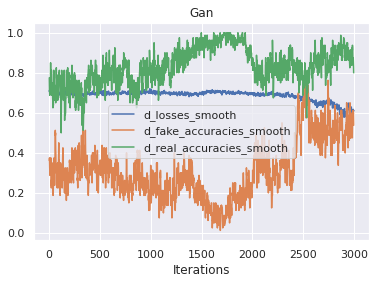

In [45]:
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    epochs = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(epochs, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 5), moving_average(d_fake_accuracies.reshape((iterations)), 5), moving_average(d_real_accuracies.reshape((iterations)), 5)

plot_metric_general([d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth']) 

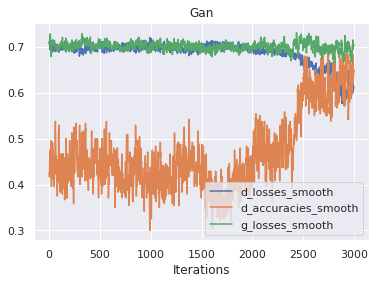

In [46]:
d_losses_smooth, d_accuracies_smooth, g_losses_smooth, g_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 5), moving_average(d_accuracies.reshape((iterations)), 5), moving_average(g_losses.reshape((iterations)), 5), moving_average(g_accuracies.reshape((iterations)), 5)

plot_metric_general([d_losses_smooth, d_accuracies_smooth, g_losses_smooth], ['d_losses_smooth', 'd_accuracies_smooth', 'g_losses_smooth'])

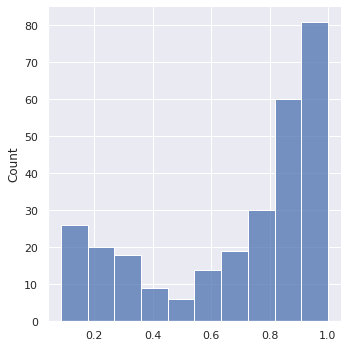

In [47]:
p_proba = gs_rf.predict_proba(df_test)[:,0]
sns.displot(p_proba, bins=10)

In [48]:
print(f'min {min(p_proba)}, max {max(p_proba)}, avg {sum(p_proba)/len(p_proba)}')

min 0.08633333333333333, max 1.0, avg 0.6852434465291608


In [33]:
# smaples_len = 1000
# noise = np.random.uniform(-1, 1, size=(smaples_len, 30))
# # c = np.random.uniform(size=(smaples_len, ))
# c = np.random.random(size=(smaples_len, ))
# loaded_generator = tf.keras.models.load_model('generator_model_7600.h5')
# # samples = gan.generator.predict([noise, c])
# samples = loaded_generator.predict([noise, c])

In [34]:
# p_proba_s = gs_rf.predict_proba(samples)[:,0]
# sns.displot(p_proba_s, bins=10)

In [35]:
# print(f'min {min(p_proba_s)}, max {max(p_proba_s)}, avg {sum(p_proba_s)/len(p_proba_s)}')

In [49]:
def test_spesific_confidence_range(low, high):
  smaples_len = 1000
  noise = np.random.uniform(-1, 1, size=(smaples_len, 30))
  c = np.random.uniform(low, high, size=(smaples_len, ))
  loaded_generator = tf.keras.models.load_model('generator_model_2500.h5')
  # samples = gan.generator.predict([noise, c])
  # c_mean = np.ones((smaples_len ,)) * np.mean(c)
  # c_std = np.ones((smaples_len , )) * np.std(c)    
  samples = loaded_generator.predict([noise, c])
  p_proba_s = gs_rf.predict_proba(samples)[:,0]
  sns.displot(p_proba_s, bins=10)
  print(f'min {min(p_proba_s)}, max {max(p_proba_s)}, avg {sum(p_proba_s)/len(p_proba_s)}')

min 0.32, max 0.62, avg 0.5359100000000001


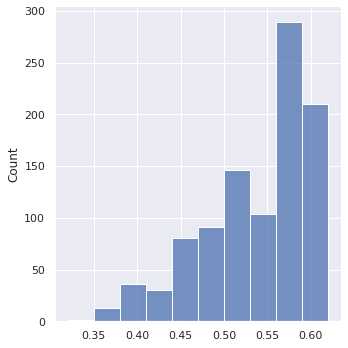

In [50]:
test_spesific_confidence_range(0.1, 0.3)

min 0.35, max 0.64, avg 0.5315399999999979


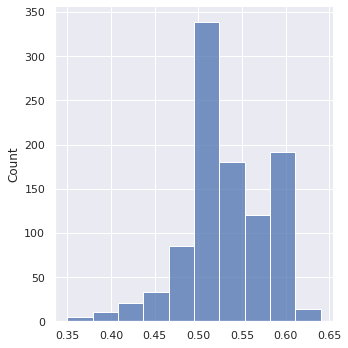

In [51]:
test_spesific_confidence_range(0.3, 0.7)

min 0.36, max 0.63, avg 0.5255899999999958


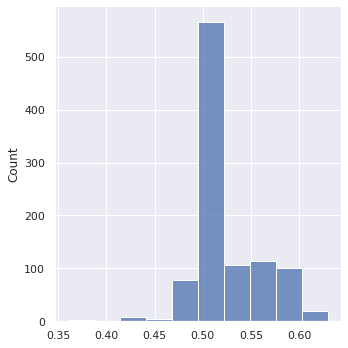

In [54]:
test_spesific_confidence_range(0.7, 0.9)